# MedQA Fine-Tuning: Teaching an LLM to Pass a Medical Exam

**Task:** Fine-tune Mistral-7B-Instruct-v0.3 on USMLE-style medical multiple-choice questions using QLoRA.

**Dataset:** MedQA (12,723 examples from US Medical Licensing Examination)

**Metric:** Accuracy (4-option MCQ)

**CS614 - Gen AI with LLMs | Individual Assignment**

## 0. Setup & Installation

In [ ]:
# ── Google Colab Setup ────────────────────────────────────
# Run this cell first on Colab to clone the repo and install deps. (THIS IS IF YOU CLONED FROM GITHUB)
# Locally, this cell is a no-op.

import os

IN_COLAB = "COLAB_GPU" in os.environ or "COLAB_RELEASE_TAG" in os.environ

if IN_COLAB:
    from getpass import getpass
    from google.colab import drive

    # Mount Google Drive for persistent storage
    drive.mount("/content/drive")

    # Clone repo (only if not already cloned)
    if not os.path.exists("/content/cs614-assignment-1"):
        token = getpass("GitHub PAT: ")
        !git clone https://{token}@github.com/ikhwanwahid/cs614-assignment-1.git /content/cs614-assignment-1
        del token  # don't keep token in memory

    # Change to project root
    os.chdir("/content/cs614-assignment-1")

    # Install dependencies
    !pip install -q transformers datasets peft bitsandbytes trl accelerate
    !pip install -q scikit-learn matplotlib pandas tqdm

import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..")) if not IN_COLAB else os.getcwd()
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Persistent results directory: Google Drive on Colab, local otherwise
if IN_COLAB:
    RESULTS_DIR = "/content/drive/MyDrive/cs614_results"
else:
    RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")

os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Results dir: {RESULTS_DIR}")
print(f"Running on Colab: {IN_COLAB}")

Mounted at /content/drive
GitHub PAT: ··········
Cloning into '/content/cs614-assignment-1'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 51 (delta 22), reused 43 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 194.84 KiB | 1.61 MiB/s, done.
Resolving deltas: 100% (22/22), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 52.9 MB/s eta 0:00:00
Project root: /content/cs614-assignment-1
Results dir: /content/drive/MyDrive/cs614_results
Running on Colab: True


In [ ]:
#USE THIS IF U UPLOADED THE PROEJCT INTO GDRIVE VIA
#PRE-requisite ensure the entire project dir is in google drive 

import os
import sys

IN_COLAB = True

# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

# Point to your uploaded project folder
# CHANGE THIS PATH if you uploaded to a different location
PROJECT_ROOT = "/content/drive/MyDrive/cs614-assignment-1"
os.chdir(PROJECT_ROOT)

# Install dependencies
!pip install -q transformers datasets peft bitsandbytes trl accelerate
!pip install -q scikit-learn matplotlib pandas tqdm scipy

# Add project root to Python path
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Results directory (persistent on Drive)
RESULTS_DIR = "/content/drive/MyDrive/cs614_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Results dir: {RESULTS_DIR}")
print(f"Running on Colab: {IN_COLAB}")

## 1. Imports & Configuration

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from configs.hyperparams import ExperimentConfig, get_all_configs
from src.data_loader import (
    format_for_inference,
    format_for_training,
    load_medqa_dataset,
    prepare_datasets,
    LABEL_MAP,
)
from src.model_loader import load_base_model_and_tokenizer, load_finetuned_model
from src.trainer import create_trainer, train_and_save
from src.evaluator import (
    compare_models,
    confidence_calibration,
    error_analysis,
    evaluate_on_dataset,
)
from src.baselines import run_few_shot_baseline, run_zero_shot_baseline
from src.topic_classifier import classify_dataset
from src.utils import (
    plot_all_configs_comparison,
    plot_calibration_curve,
    plot_error_taxonomy,
    plot_per_topic_accuracy,
    plot_training_curves,
    save_results_json,
    set_seed,
    setup_device,
)

set_seed(42)
device = setup_device()

GPU: NVIDIA H100 80GB HBM3
VRAM: 85.0 GB


## 2. Load & Explore Data

In [ ]:
train_raw, val_raw, test_raw = load_medqa_dataset()

print(f"Train: {len(train_raw):,} examples")
print(f"Val:   {len(val_raw):,} examples")
print(f"Test:  {len(test_raw):,} examples")
print(f"\nColumns: {train_raw.column_names}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/640 [00:00<?, ?B/s]

train.json: 0.00B [00:00, ?B/s]

dev.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/10178 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1272 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1273 [00:00<?, ? examples/s]

Train: 10,178 examples
Val:   1,272 examples
Test:  1,273 examples

Columns: ['id', 'sent1', 'sent2', 'ending0', 'ending1', 'ending2', 'ending3', 'label']


In [ ]:
# Show example questions
for i in range(3):
    ex = test_raw[i]
    print(f"\n{'='*60}")
    print(f"Example {i+1} | Answer: {LABEL_MAP[ex['label']]}")
    print(f"{'='*60}")
    print(format_for_inference(ex)[:500])


Example 1 | Answer: B
<s>[INST] You are a medical expert. Answer the following USMLE-style multiple-choice question by selecting the single best answer. Respond with ONLY the letter (A, B, C, or D) of the correct answer.

A junior orthopaedic surgery resident is completing a carpal tunnel repair with the department chairman as the attending physician. During the case, the resident inadvertently cuts a flexor tendon. The tendon is repaired without complication. The attending tells the resident that the patient will do

Example 2 | Answer: D
<s>[INST] You are a medical expert. Answer the following USMLE-style multiple-choice question by selecting the single best answer. Respond with ONLY the letter (A, B, C, or D) of the correct answer.

A 67-year-old man with transitional cell carcinoma of the bladder comes to the physician because of a 2-day history of ringing sensation in his ear. He received this first course of neoadjuvant chemotherapy 1 week ago. Pure tone audiometry shows a senso

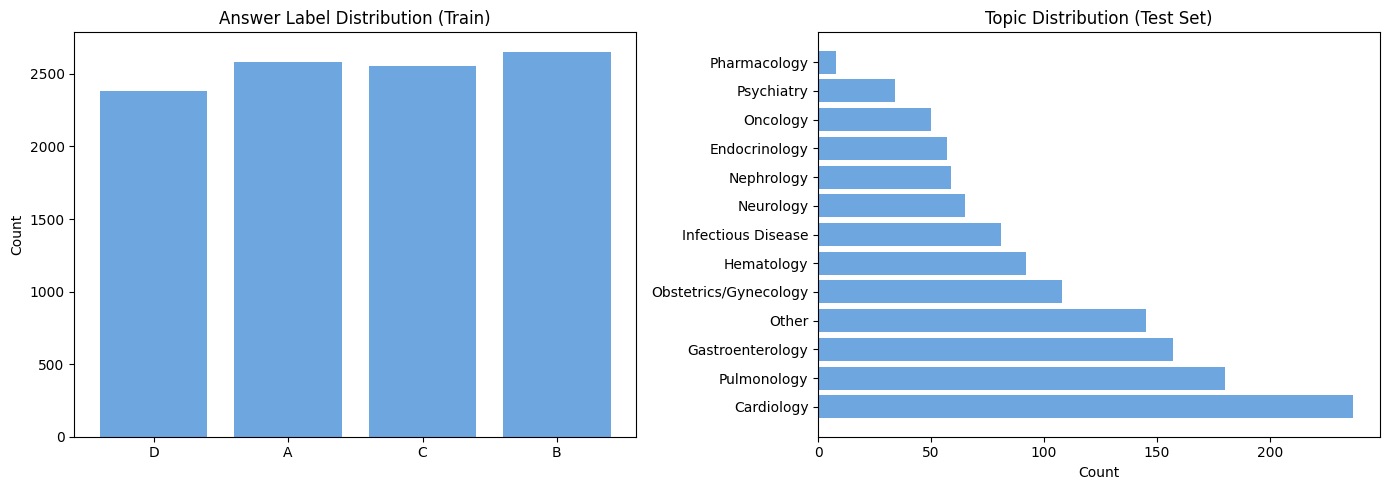


Topics in test set:
  Cardiology: 237 (18.6%)
  Pulmonology: 180 (14.1%)
  Gastroenterology: 157 (12.3%)
  Other: 145 (11.4%)
  Obstetrics/Gynecology: 108 (8.5%)
  Hematology: 92 (7.2%)
  Infectious Disease: 81 (6.4%)
  Neurology: 65 (5.1%)
  Nephrology: 59 (4.6%)
  Endocrinology: 57 (4.5%)
  Oncology: 50 (3.9%)
  Psychiatry: 34 (2.7%)
  Pharmacology: 8 (0.6%)


In [ ]:
# Answer label distribution
train_labels = [LABEL_MAP[ex["label"]] for ex in train_raw]
label_counts = Counter(train_labels)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Label distribution
axes[0].bar(label_counts.keys(), label_counts.values(), color="#4a90d9", alpha=0.8)
axes[0].set_title("Answer Label Distribution (Train)")
axes[0].set_ylabel("Count")

# Topic distribution
test_topics = classify_dataset(test_raw)
topic_counts = Counter(test_topics)
topics_sorted = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)
axes[1].barh([t[0] for t in topics_sorted], [t[1] for t in topics_sorted],
             color="#4a90d9", alpha=0.8)
axes[1].set_title("Topic Distribution (Test Set)")
axes[1].set_xlabel("Count")

plt.tight_layout()
plt.show()

print(f"\nTopics in test set:")
for topic, count in topics_sorted:
    print(f"  {topic}: {count} ({count/len(test_raw)*100:.1f}%)")

## 3. Zero-Shot Baseline (Base Model)

Evaluate the base Mistral-7B-Instruct model with no fine-tuning.

In [ ]:
base_config = ExperimentConfig(name="base_model")
base_model, base_tokenizer = load_base_model_and_tokenizer(base_config, for_training=False)
# Set left padding for generation
base_tokenizer.padding_side = "left"

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
zero_shot_results = run_zero_shot_baseline(
    base_model, base_tokenizer, test_raw,
    topic_labels=test_topics, batch_size=8,
)

print(f"Zero-shot accuracy: {zero_shot_results['overall_accuracy']:.4f}")
print(f"Zero-shot macro F1: {zero_shot_results['macro_f1']:.4f}")
print(f"Extraction failure rate: {zero_shot_results['extraction_failure_rate']:.4f}")

save_results_json(zero_shot_results, os.path.join(RESULTS_DIR, "zero_shot_results.json"))

Running inference on 1273 examples...
Zero-shot accuracy: 0.4910
Zero-shot macro F1: 0.4929
Extraction failure rate: 0.0118


## 4. Few-Shot Baseline (Base Model)

Evaluate with 3 training examples as in-context exemplars.

In [ ]:
few_shot_results = run_few_shot_baseline(
    base_model, base_tokenizer, test_raw, train_raw,
    n_shots=3, topic_labels=test_topics, batch_size=4,
)

print(f"3-shot accuracy: {few_shot_results['overall_accuracy']:.4f}")
print(f"3-shot macro F1: {few_shot_results['macro_f1']:.4f}")
print(f"Extraction failure rate: {few_shot_results['extraction_failure_rate']:.4f}")

save_results_json(few_shot_results, os.path.join(RESULTS_DIR, "few_shot_results.json"))

Running 3-shot baseline on 1273 examples...
3-shot accuracy: 0.4902
3-shot macro F1: 0.4888
Extraction failure rate: 0.0165


In [ ]:
# Free GPU memory before training
del base_model
torch.cuda.empty_cache()
print("GPU memory freed.")

GPU memory freed.


## 5. Hyperparameter Sweep -- Training

Train 6 configurations varying LoRA rank, learning rate, epochs, and dropout.

| Config | What it tests | Key difference |
|--------|--------------|----------------|
| 1 (Baseline) | Standard QLoRA defaults | r=16, lr=2e-4, 2 epochs |
| 2 (Low Rank) | Fewer params sufficient? | r=8, alpha=16 |
| 3 (High Rank) | More capacity helps? | r=64, alpha=128, lr=1e-4 |
| 4 (Low LR) | Slower convergence? | lr=5e-5, 3 epochs |
| 5 (Extended) | Optimal stopping point | 3 epochs, lr=2e-4 |
| 6 (Aggressive) | Speed + regularization | r=32, lr=3e-4, dropout=0.1 |

In [ ]:
configs = get_all_configs()
all_training_logs = {}
all_val_results = {}

for config_name, config in configs.items():
    print(f"\n{'='*60}")
    print(f"Training: {config_name}")
    print(f"Description: {config.description}")
    print(f"{'='*60}")

    # Override output_dir to save to Google Drive
    config.output_dir = RESULTS_DIR

    set_seed(config.seed)

    # Prepare data
    train_ds, val_ds, _ = prepare_datasets(config)

    # Load model with LoRA
    model, tokenizer = load_base_model_and_tokenizer(config, for_training=True)

    # Train
    trainer = create_trainer(model, tokenizer, train_ds, val_ds, config)
    training_metrics = train_and_save(trainer, config)
    all_training_logs[config_name] = training_metrics["log_history"]

    # Quick validation accuracy
    tokenizer.padding_side = "left"  # switch for generation
    val_results = evaluate_on_dataset(model, tokenizer, val_raw, batch_size=8)
    all_val_results[config_name] = val_results
    print(f"  Val accuracy: {val_results['overall_accuracy']:.4f}")

    # Save val results to Drive
    save_results_json(val_results, os.path.join(RESULTS_DIR, f"{config_name}/val_results.json"))

    # Free memory
    del model, trainer
    torch.cuda.empty_cache()

print("\n" + "="*60)
print("All training complete!")
print("="*60)


Training: config_1_baseline
Description: Baseline: r=16, alpha=32, lr=2e-4, 2 epochs. Standard starting point from QLoRA literature.


Map:   0%|          | 0/10178 [00:00<?, ? examples/s]

Map:   0%|          | 0/1272 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Trainable: 41,943,040 / 3,800,305,664 (1.10%)


Adding EOS to train dataset:   0%|          | 0/10178 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/10178 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/10178 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/1272 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/1272 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/1272 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Step,Training Loss,Validation Loss
100,1.020563,1.012430
200,1.004422,0.998013
300,0.985742,0.984512
400,0.998008,0.977100
500,0.962083,0.968639
600,0.948197,0.959363
700,0.817143,0.970239
800,0.797011,0.968882
900,0.794636,0.964504



Training complete: config_1_baseline
  Time: 29.5 min
  Best eval loss: 0.9593634605407715
  Adapter saved to: /content/drive/MyDrive/cs614_results/config_1_baseline/adapter
Running inference on 1272 examples...
  Val accuracy: 0.5582

Training: config_2_low_rank
Description: Low rank: r=8, alpha=16. Tests whether fewer trainable parameters suffice for MCQ classification, reducing overfitting risk.


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Trainable: 20,971,520 / 3,779,334,144 (0.55%)


Step,Training Loss,Validation Loss
100,1.021729,1.010241
200,1.000247,0.993710
300,0.980105,0.980955
400,0.993811,0.973089
500,0.959650,0.965998
600,0.946831,0.958321
700,0.857326,0.963546
800,0.840402,0.961391
900,0.840409,0.958791



Training complete: config_2_low_rank
  Time: 29.6 min
  Best eval loss: 0.958321213722229
  Adapter saved to: /content/drive/MyDrive/cs614_results/config_2_low_rank/adapter
Running inference on 1272 examples...
  Val accuracy: 0.5629

Training: config_3_high_rank
Description: High rank: r=64, alpha=128. Tests whether increased capacity captures more nuanced medical reasoning. Lower LR to compensate.


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Trainable: 167,772,160 / 3,926,134,784 (4.27%)


Step,Training Loss,Validation Loss
100,1.023985,1.016934
200,1.006264,0.998992
300,0.984400,0.983228
400,0.993662,0.973563
500,0.959300,0.963980
600,0.941013,0.952664
700,0.756736,0.972896
800,0.734840,0.975774
900,0.728880,0.970645



Training complete: config_3_high_rank
  Time: 30.0 min
  Best eval loss: 0.9526644349098206
  Adapter saved to: /content/drive/MyDrive/cs614_results/config_3_high_rank/adapter
Running inference on 1272 examples...
  Val accuracy: 0.5668

Training: config_4_low_lr
Description: Lower LR: 5e-5 with r=16. Tests whether slower learning produces more stable convergence and better generalization. More epochs to compensate.


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Trainable: 41,943,040 / 3,800,305,664 (1.10%)


Step,Training Loss,Validation Loss
100,1.061164,1.024983
200,1.005364,0.996553
300,0.982502,0.985458
400,0.998750,0.975137
500,0.962804,0.968872
600,0.952432,0.963279
700,0.903537,0.963650
800,0.892844,0.961486
900,0.897000,0.959831
1000,0.901256,0.956861



Training complete: config_4_low_lr
  Time: 49.2 min
  Best eval loss: 0.9514952898025513
  Adapter saved to: /content/drive/MyDrive/cs614_results/config_4_low_lr/adapter
Running inference on 1272 examples...
  Val accuracy: 0.5739

Training: config_5_longer_training
Description: Extended: 3 epochs at lr=2e-4. Tests benefit of additional passes vs. overfitting. Should reveal optimal epoch count.


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Trainable: 41,943,040 / 3,800,305,664 (1.10%)


Step,Training Loss,Validation Loss
100,1.022016,1.014237
200,1.007187,1.001462
300,0.989397,0.988192
400,1.003705,0.983066
500,0.970036,0.976689
600,0.958574,0.968524
700,0.834507,0.980103
800,0.821688,0.981465
900,0.825346,0.976619



Training complete: config_5_longer_training
  Time: 29.6 min
  Best eval loss: 0.9685236811637878
  Adapter saved to: /content/drive/MyDrive/cs614_results/config_5_longer_training/adapter
Running inference on 1272 examples...
  Val accuracy: 0.5299

Training: config_6_aggressive
Description: Aggressive: r=32, alpha=64, lr=3e-4, dropout=0.1. Pushes capacity and learning speed with dropout as regularizer.


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Trainable: 83,886,080 / 3,842,248,704 (2.18%)


Step,Training Loss,Validation Loss
100,1.058079,1.051221
200,1.058663,1.050710
300,1.045004,1.045625
400,1.060845,1.032887
500,1.026210,1.020318
600,0.993504,1.003166
700,0.801233,1.012740
800,0.775862,1.006572
900,0.764277,0.996334
1000,0.762689,0.984990



Training complete: config_6_aggressive
  Time: 42.9 min
  Best eval loss: 0.9810243844985962
  Adapter saved to: /content/drive/MyDrive/cs614_results/config_6_aggressive/adapter
Running inference on 1272 examples...
  Val accuracy: 0.5134

All training complete!


## 6. Training Curves

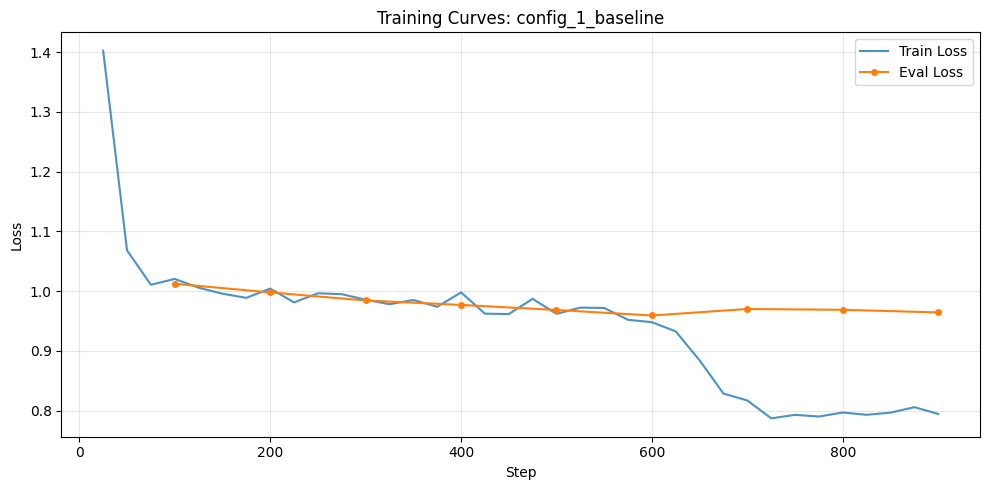

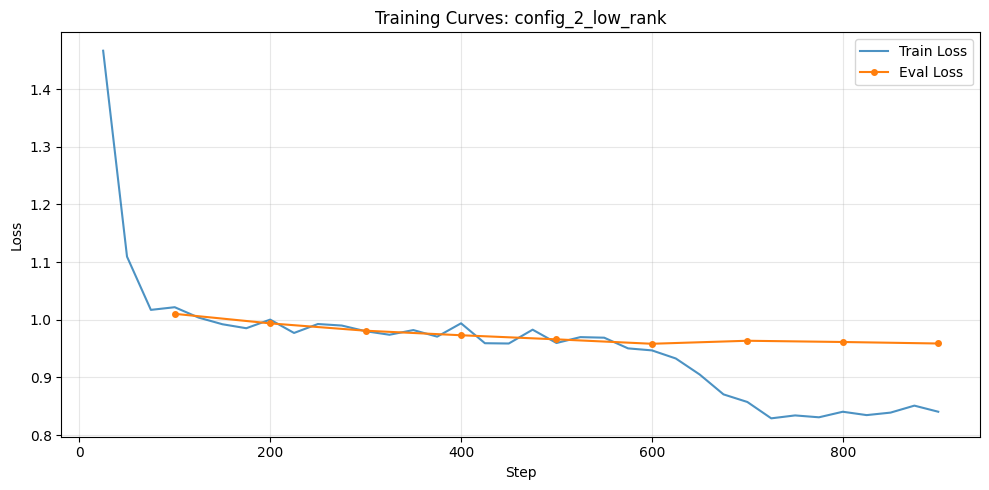

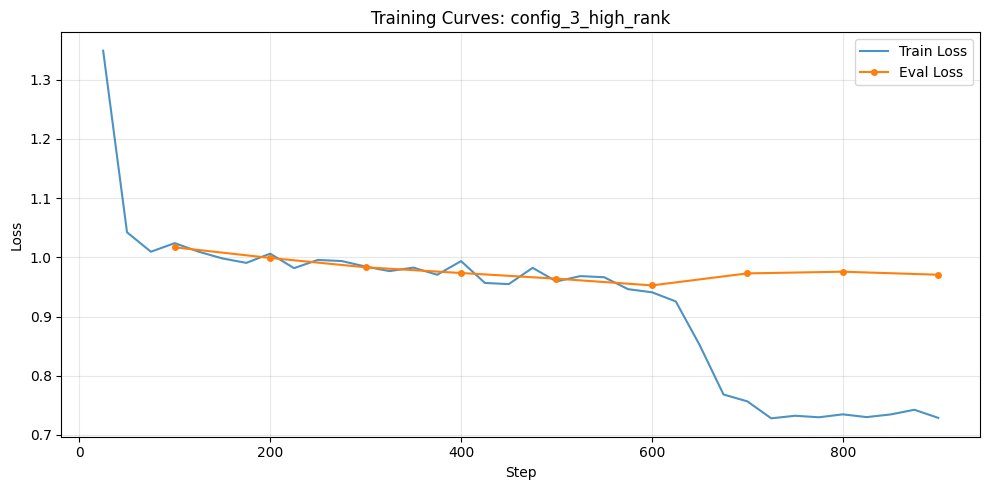

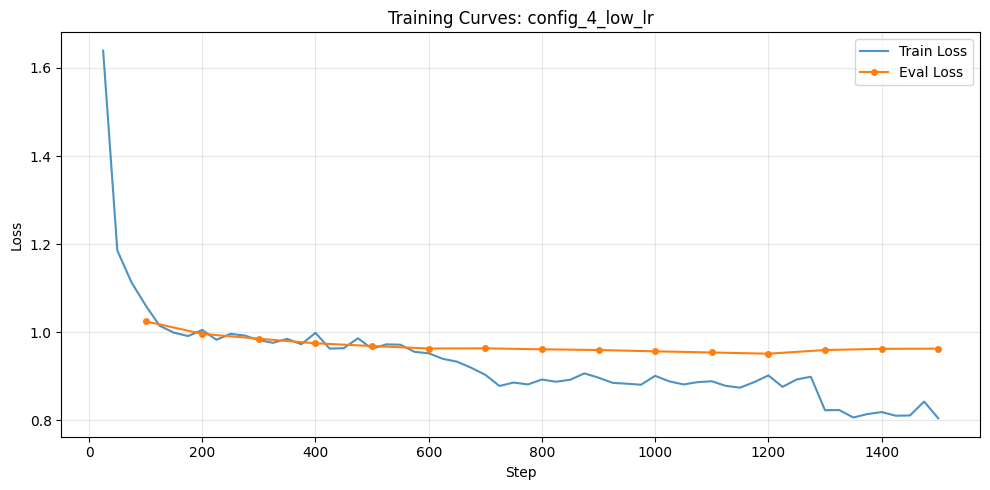

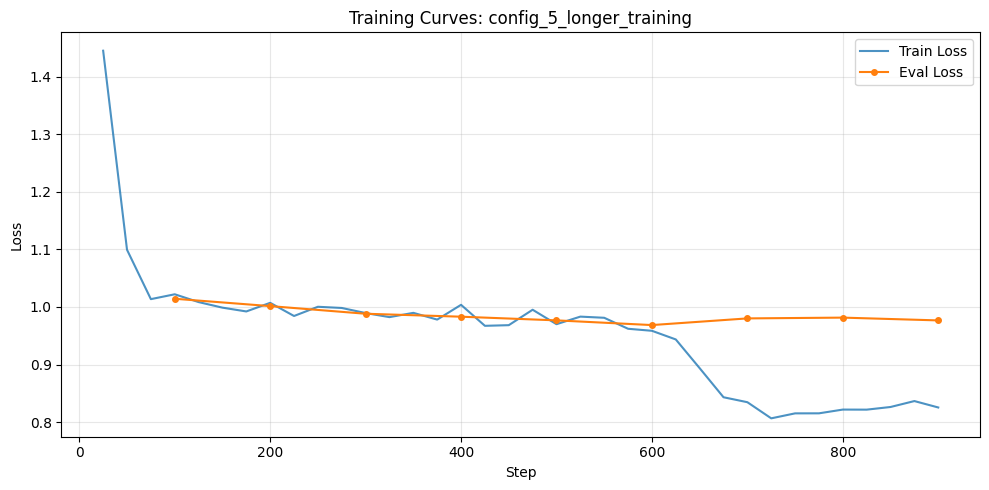

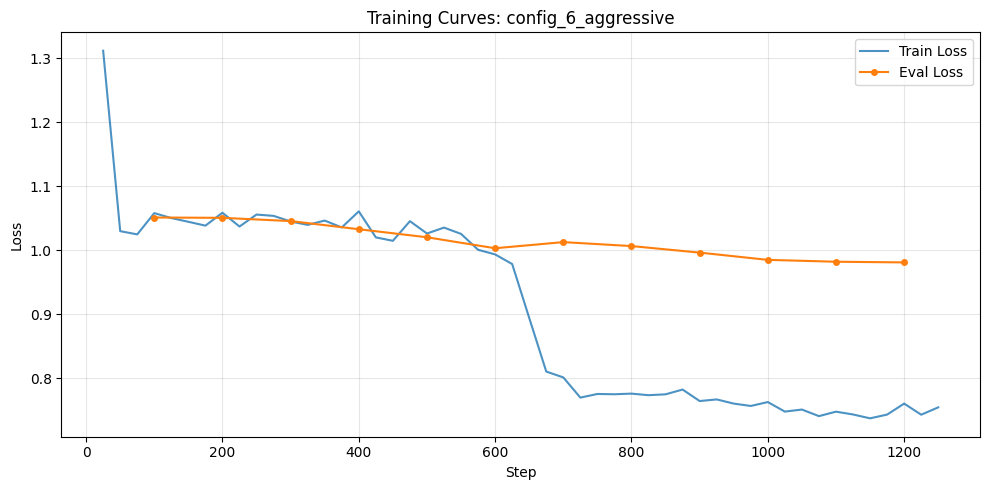

In [ ]:
# Individual training curves
for config_name, log_history in all_training_logs.items():
    plot_training_curves(
        log_history, title=f"Training Curves: {config_name}",
        save_path=os.path.join(RESULTS_DIR, f"{config_name}/training_curve.png"),
    )

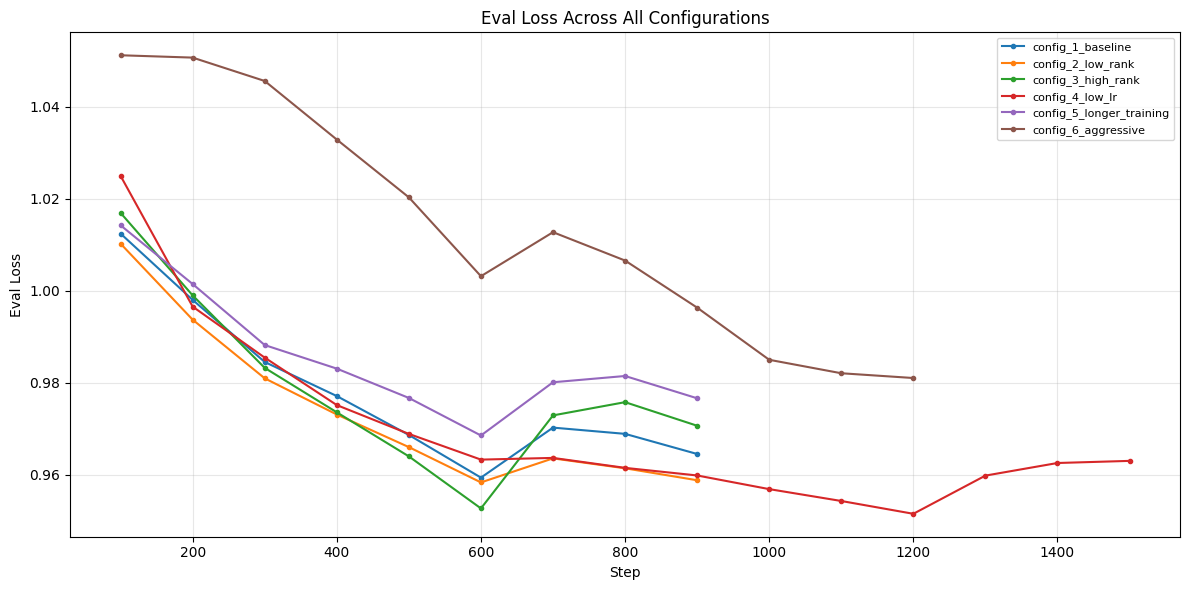

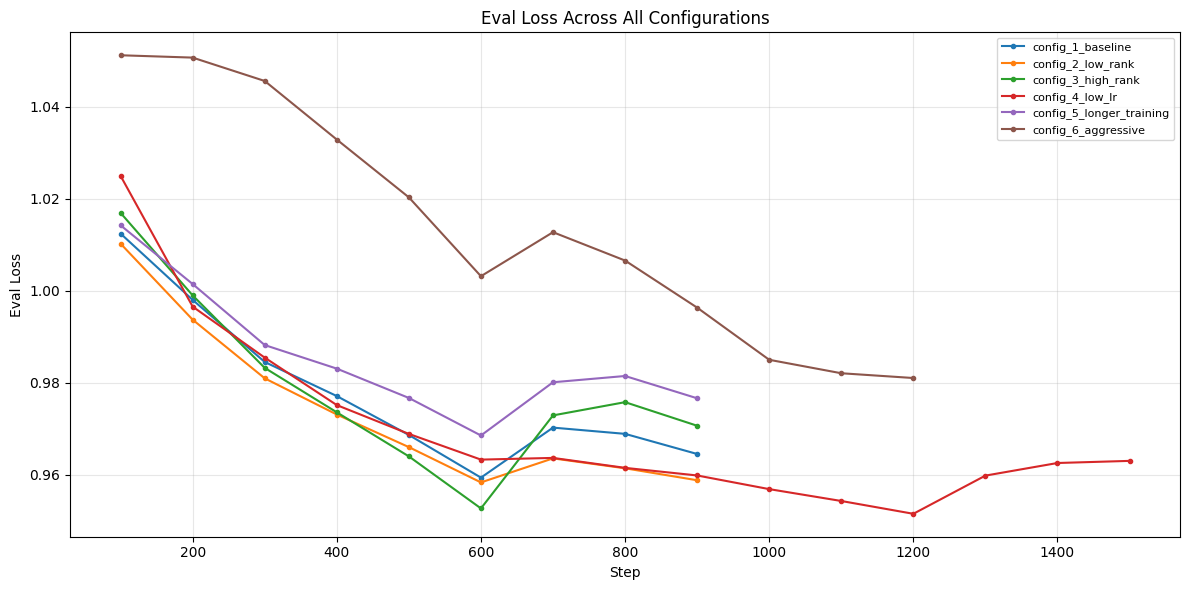

In [ ]:
# All configs overlaid
plot_all_configs_comparison(
    all_training_logs,
    save_path=os.path.join(RESULTS_DIR, "all_configs_comparison.png"),
)

In [ ]:
# Validation accuracy summary table
val_summary = []
for name, res in all_val_results.items():
    val_summary.append({
        "Config": name,
        "Val Accuracy": f"{res['overall_accuracy']:.4f}",
        "Val Macro F1": f"{res['macro_f1']:.4f}",
        "Extraction Failures": f"{res['extraction_failure_rate']:.4f}",
    })

val_df = pd.DataFrame(val_summary).sort_values("Val Accuracy", ascending=False)
print(val_df.to_string(index=False))

best_config_name = val_df.iloc[0]["Config"]
print(f"\nBest config: {best_config_name}")

                  Config Val Accuracy Val Macro F1 Extraction Failures
         config_4_low_lr       0.5739       0.5716              0.0000
      config_3_high_rank       0.5668       0.5667              0.0000
       config_2_low_rank       0.5629       0.5620              0.0000
       config_1_baseline       0.5582       0.5562              0.0000
config_5_longer_training       0.5299       0.5283              0.0000
     config_6_aggressive       0.5134       0.5115              0.0000

Best config: config_4_low_lr


## 7. Best Config -- Full Test Evaluation

In [ ]:
# Load the best fine-tuned model
best_config = configs[best_config_name]
best_config.output_dir = RESULTS_DIR
adapter_path = os.path.join(RESULTS_DIR, f"{best_config_name}/adapter")

ft_model, ft_tokenizer = load_finetuned_model(best_config, adapter_path)
print(f"Loaded adapter from: {adapter_path}")

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Loaded adapter from: /content/drive/MyDrive/cs614_results/config_4_low_lr/adapter


In [ ]:
# Full test set evaluation
ft_results = evaluate_on_dataset(
    ft_model, ft_tokenizer, test_raw,
    topic_labels=test_topics, batch_size=8,
)

print(f"Fine-tuned accuracy: {ft_results['overall_accuracy']:.4f}")
print(f"Fine-tuned macro F1: {ft_results['macro_f1']:.4f}")
print(f"Extraction failures: {ft_results['extraction_failure_rate']:.4f}")
print(f"\nClassification Report:\n{ft_results['classification_report']}")

save_results_json(ft_results, os.path.join(RESULTS_DIR, "finetuned_test_results.json"))

Running inference on 1273 examples...
Fine-tuned accuracy: 0.5742
Fine-tuned macro F1: 0.5695
Extraction failures: 0.0016

Classification Report:
              precision    recall  f1-score   support

           A       0.62      0.58      0.60       353
           B       0.52      0.59      0.55       309
           C       0.61      0.63      0.62       346
           D       0.54      0.48      0.50       265

   micro avg       0.58      0.57      0.57      1273
   macro avg       0.57      0.57      0.57      1273
weighted avg       0.58      0.57      0.57      1273



## 8. Comparison: Zero-Shot vs Few-Shot vs Fine-Tuned

In [ ]:
comparison = compare_models(zero_shot_results, ft_results, few_shot_results)

comp_df = pd.DataFrame({
    "Metric": ["Accuracy", "Macro F1", "Extraction Failure Rate"],
    "Zero-Shot": [
        comparison["zero_shot"]["accuracy"],
        comparison["zero_shot"]["macro_f1"],
        comparison["zero_shot"]["extraction_failures"],
    ],
    "3-Shot": [
        comparison["few_shot"]["accuracy"],
        comparison["few_shot"]["macro_f1"],
        comparison["few_shot"]["extraction_failures"],
    ],
    "Fine-Tuned": [
        comparison["fine_tuned"]["accuracy"],
        comparison["fine_tuned"]["macro_f1"],
        comparison["fine_tuned"]["extraction_failures"],
    ],
})

print(comp_df.to_string(index=False))
print(f"\nAccuracy improvement (fine-tuned vs zero-shot): +{comparison['delta']['accuracy']:.4f}")

save_results_json(comparison, os.path.join(RESULTS_DIR, "comparison_summary.json"))

                 Metric  Zero-Shot  3-Shot  Fine-Tuned
               Accuracy     0.4910  0.4902      0.5742
               Macro F1     0.4929  0.4888      0.5695
Extraction Failure Rate     0.0118  0.0165      0.0016

Accuracy improvement (fine-tuned vs zero-shot): +0.0832


## 9. Per-Topic Accuracy Breakdown

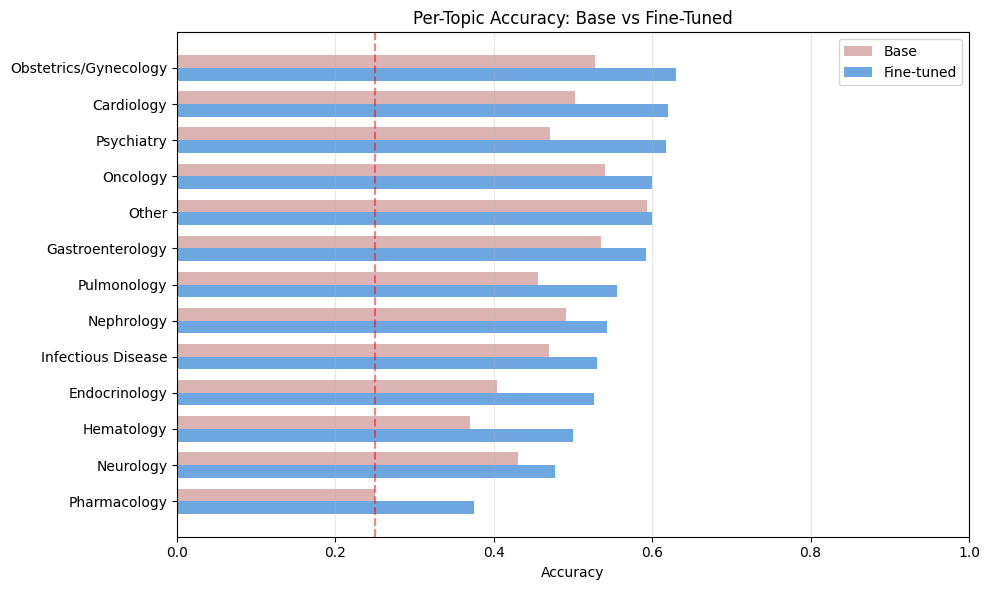

                Topic Base Accuracy Fine-Tuned Accuracy  Delta
Obstetrics/Gynecology         0.528               0.630 +0.102
           Cardiology         0.502               0.620 +0.118
           Psychiatry         0.471               0.618 +0.147
                Other         0.593               0.600 +0.007
             Oncology         0.540               0.600 +0.060
     Gastroenterology         0.535               0.592 +0.057
          Pulmonology         0.456               0.556 +0.100
           Nephrology         0.492               0.542 +0.051
   Infectious Disease         0.469               0.531 +0.062
        Endocrinology         0.404               0.526 +0.123
           Hematology         0.370               0.500 +0.130
            Neurology         0.431               0.477 +0.046
         Pharmacology         0.250               0.375 +0.125


In [ ]:
plot_per_topic_accuracy(
    ft_results["per_topic_accuracy"],
    base_per_topic=zero_shot_results.get("per_topic_accuracy"),
    title="Per-Topic Accuracy: Base vs Fine-Tuned",
    save_path=os.path.join(RESULTS_DIR, "per_topic_accuracy.png"),
)

# Print per-topic table
topic_df = pd.DataFrame([
    {
        "Topic": topic,
        "Base Accuracy": f"{zero_shot_results.get('per_topic_accuracy', {}).get(topic, 0):.3f}",
        "Fine-Tuned Accuracy": f"{acc:.3f}",
        "Delta": f"{acc - zero_shot_results.get('per_topic_accuracy', {}).get(topic, 0):+.3f}",
    }
    for topic, acc in sorted(ft_results["per_topic_accuracy"].items(),
                             key=lambda x: x[1], reverse=True)
])
print(topic_df.to_string(index=False))

## 10. Error Analysis

In [ ]:
errors = error_analysis(ft_results["predictions"])

print(f"Total errors: {errors['total_errors']} / {ft_results['n_total']}")
print(f"\nError breakdown:")
for cat, count in errors["error_counts"].items():
    print(f"  {cat}: {count}")

print(f"\nMost confused answer pairs (gold -> predicted):")
for (gold, pred), count in errors["most_confused_pairs"][:5]:
    print(f"  {gold} -> {pred}: {count} times")

Total errors: 542 / 1273

Error breakdown:
  extraction_failure: 2
  substantive_error: 540

Most confused answer pairs (gold -> predicted):
  A -> B: 62 times
  C -> B: 55 times
  D -> B: 51 times
  A -> C: 48 times
  B -> C: 48 times


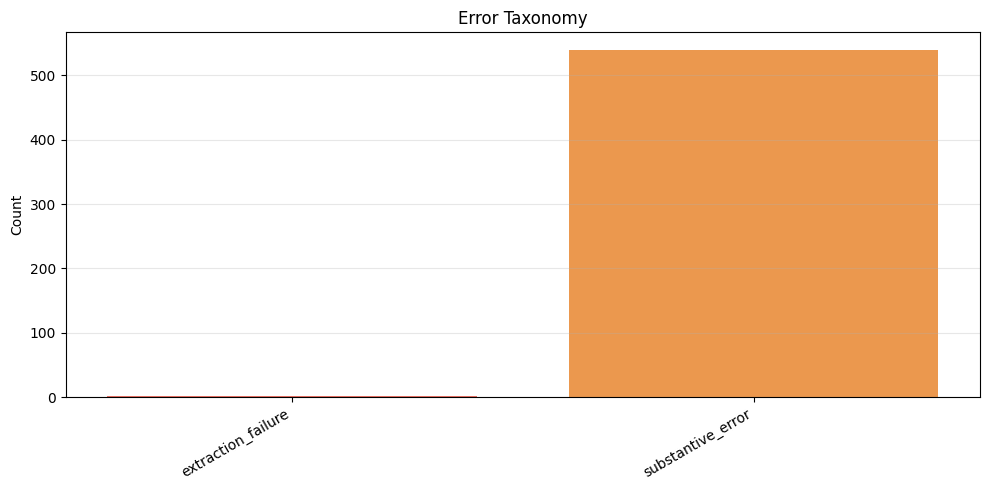


Example substantive errors:

  Q index: 0
  Gold: B | Predicted: A
  Topic: Other
  Raw output: A

  Q index: 1
  Gold: D | Predicted: B
  Topic: Oncology
  Raw output: B

  Q index: 3
  Gold: D | Predicted: B
  Topic: Obstetrics/Gynecology
  Raw output: B


In [ ]:
plot_error_taxonomy(
    errors["error_counts"],
    save_path=os.path.join(RESULTS_DIR, "error_taxonomy.png"),
)

# Show example errors
print("\nExample substantive errors:")
for ex in errors["error_examples"]["substantive_error"][:3]:
    print(f"\n  Q index: {ex['idx']}")
    print(f"  Gold: {ex['gold']} | Predicted: {ex['pred']}")
    print(f"  Topic: {ex.get('topic', 'N/A')}")
    print(f"  Raw output: {ex['raw_output'][:100]}")

In [ ]:
# Error rate by topic
topic_err_df = pd.DataFrame([
    {"Topic": topic, "Error Rate": f"{rate:.3f}"}
    for topic, rate in sorted(errors["topic_error_rates"].items(),
                               key=lambda x: x[1], reverse=True)
])
print("Error rate by topic:")
print(topic_err_df.to_string(index=False))

Error rate by topic:
                Topic Error Rate
         Pharmacology      0.625
            Neurology      0.523
           Hematology      0.500
        Endocrinology      0.474
   Infectious Disease      0.469
           Nephrology      0.458
          Pulmonology      0.444
     Gastroenterology      0.408
                Other      0.400
             Oncology      0.400
           Psychiatry      0.382
           Cardiology      0.380
Obstetrics/Gynecology      0.370


In [ ]:
 !cd /content/cs614-assignment-1 && git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 388 bytes | 388.00 KiB/s, done.
From https://github.com/ikhwanwahid/cs614-assignment-1
   04c1e0f..53ec837  main       -> origin/main
Updating 04c1e0f..53ec837
Fast-forward
 src/evaluator.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [ ]:
  import importlib
  import src.evaluator
  importlib.reload(src.evaluator)
  from src.evaluator import confidence_calibration

## 11. Confidence Calibration

Calibration: 100%|██████████| 160/160 [00:32<00:00,  4.87it/s]


Expected Calibration Error (ECE): 0.2536
Avg confidence (correct):   0.5797
Avg confidence (incorrect): 0.5442


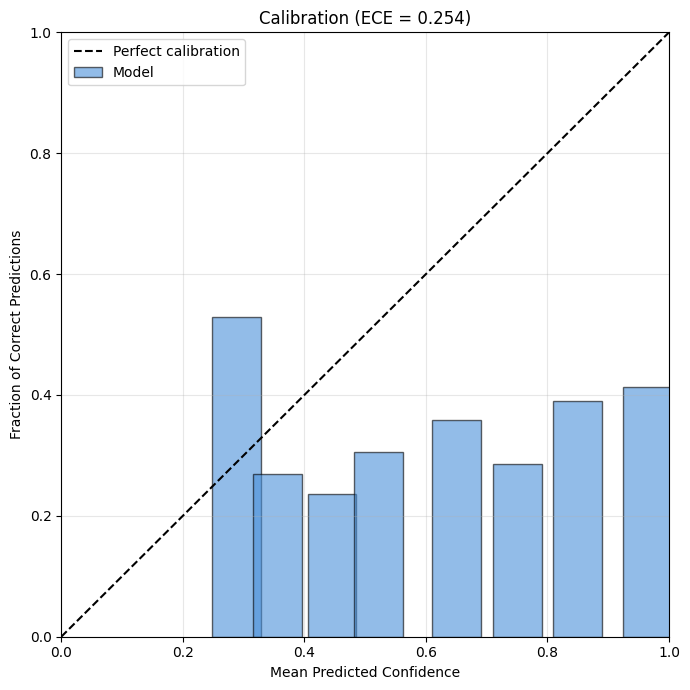

In [ ]:
cal_data = confidence_calibration(
    ft_model, ft_tokenizer, test_raw,
    topic_labels=test_topics, batch_size=8,
)

print(f"Expected Calibration Error (ECE): {cal_data['ece']:.4f}")
print(f"Avg confidence (correct):   {cal_data['avg_confidence_correct']:.4f}")
print(f"Avg confidence (incorrect): {cal_data['avg_confidence_incorrect']:.4f}")

plot_calibration_curve(
    cal_data,
    save_path=os.path.join(RESULTS_DIR, "calibration_curve.png"),
)

save_results_json(cal_data, os.path.join(RESULTS_DIR, "calibration_data.json"))

In [ ]:
from src.utils import load_results_json

zero_shot_results = load_results_json(os.path.join(RESULTS_DIR, "zero_shot_results.json"))
few_shot_results = load_results_json(os.path.join(RESULTS_DIR, "few_shot_results.json"))
ft_results = load_results_json(os.path.join(RESULTS_DIR, "finetuned_test_results.json"))
best_config_name = "config_4_low_lr"  # or whichever was best
configs = get_all_configs()
best_config = configs[best_config_name]
best_config.output_dir = RESULTS_DIR
adapter_path = os.path.join(RESULTS_DIR, f"{best_config_name}/adapter")
ft_model, ft_tokenizer = load_finetuned_model(best_config, adapter_path)

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

## 12. Answer Position Bias Analysis

Does the model disproportionately predict certain answer letters? Position bias is a known issue in LLMs where models may favor certain option positions (e.g., always picking "A" or "B") regardless of content. We compare the distribution of gold (true) labels vs predicted labels across zero-shot, few-shot, and fine-tuned models.

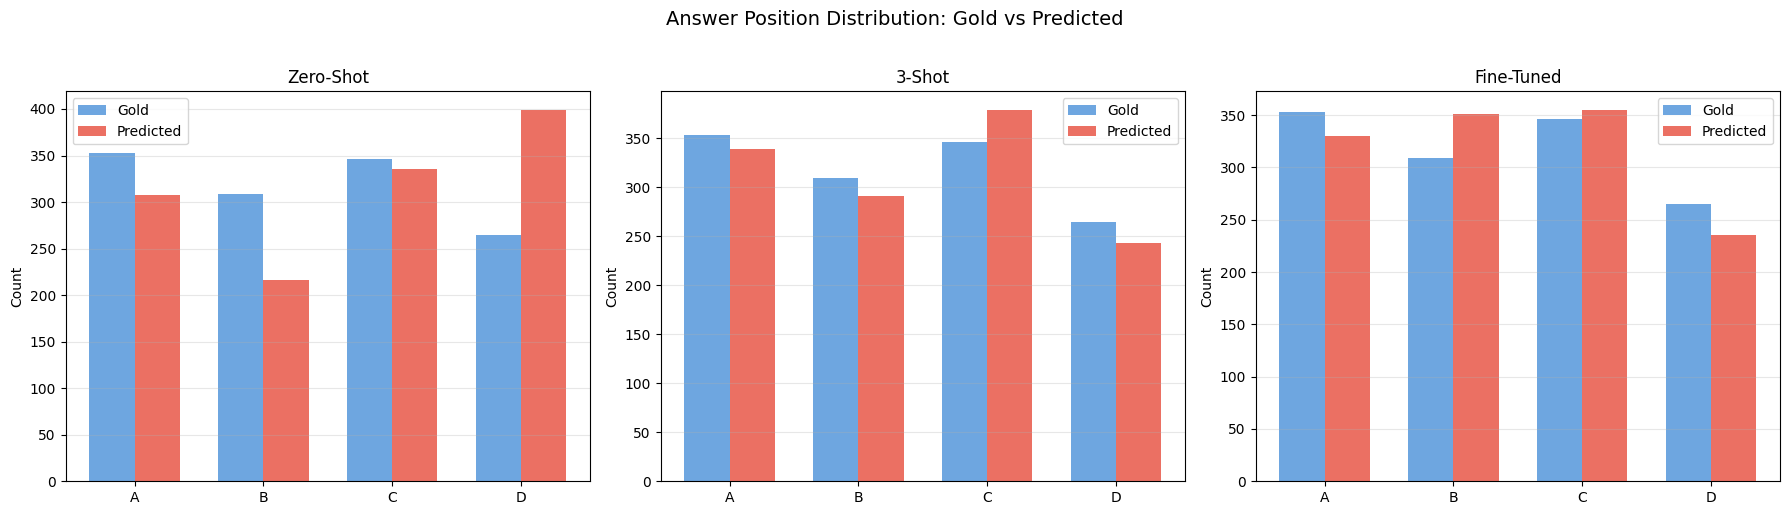


Zero-Shot:
  Letter     Gold   Pred    Delta   Pred %
  --------------------------------------
  A           353    308      -45    24.5%
  B           309    216      -93    17.2%
  C           346    335      -11    26.6%
  D           265    399     +134    31.7%
  X (fail)            15

3-Shot:
  Letter     Gold   Pred    Delta   Pred %
  --------------------------------------
  A           353    339      -14    27.1%
  B           309    291      -18    23.2%
  C           346    379      +33    30.3%
  D           265    243      -22    19.4%
  X (fail)            21

Fine-Tuned:
  Letter     Gold   Pred    Delta   Pred %
  --------------------------------------
  A           353    330      -23    26.0%
  B           309    351      +42    27.6%
  C           346    355       +9    27.9%
  D           265    235      -30    18.5%
  X (fail)             2

Chi-squared test: are predictions uniformly distributed?
  Zero-Shot: chi2=55.02, p=0.0000 (non-uniform)
  3-Shot: chi2=33

In [ ]:
# ── Answer Position Bias Analysis ──
import numpy as np

# Compare gold (true) vs predicted answer distributions
results_for_bias = {
    "Zero-Shot": zero_shot_results,
    "3-Shot": few_shot_results,
    "Fine-Tuned": ft_results,
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
letters = ["A", "B", "C", "D"]

for ax, (name, results) in zip(axes, results_for_bias.items()):
    preds = results["predictions"]
    gold_dist = Counter(p["gold"] for p in preds)
    pred_dist = Counter(p["pred"] for p in preds)

    x = np.arange(len(letters))
    width = 0.35
    gold_counts = [gold_dist.get(l, 0) for l in letters]
    pred_counts = [pred_dist.get(l, 0) for l in letters]

    ax.bar(x - width / 2, gold_counts, width, label="Gold", color="#4a90d9", alpha=0.8)
    ax.bar(x + width / 2, pred_counts, width, label="Predicted", color="#e74c3c", alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(letters)
    ax.set_ylabel("Count")
    ax.set_title(name)
    ax.legend()
    ax.grid(True, axis="y", alpha=0.3)

plt.suptitle("Answer Position Distribution: Gold vs Predicted", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "position_bias.png"), dpi=150, bbox_inches="tight")
plt.show()

# Detailed table
for name, results in results_for_bias.items():
    preds = results["predictions"]
    gold_dist = Counter(p["gold"] for p in preds)
    pred_dist = Counter(p["pred"] for p in preds)

    print(f"\n{name}:")
    print(f"  {'Letter':<8} {'Gold':>6} {'Pred':>6} {'Delta':>8} {'Pred %':>8}")
    print(f"  {'-' * 38}")
    total_pred = sum(pred_dist.get(l, 0) for l in letters)
    for letter in letters:
        g = gold_dist.get(letter, 0)
        p = pred_dist.get(letter, 0)
        pct = p / total_pred * 100 if total_pred > 0 else 0
        print(f"  {letter:<8} {g:>6} {p:>6} {p - g:>+8} {pct:>7.1f}%")

    # Check for X (extraction failures)
    x_count = pred_dist.get("X", 0)
    if x_count > 0:
        print(f"  {'X (fail)':<8} {'':>6} {x_count:>6}")

# Chi-squared test for uniformity of predictions
from scipy.stats import chisquare

print("\n" + "=" * 60)
print("Chi-squared test: are predictions uniformly distributed?")
print("=" * 60)
for name, results in results_for_bias.items():
    pred_dist = Counter(p["pred"] for p in results["predictions"])
    observed = [pred_dist.get(l, 0) for l in letters]
    total = sum(observed)
    expected = [total / 4] * 4
    stat, p_val = chisquare(observed, expected)
    print(f"  {name}: chi2={stat:.2f}, p={p_val:.4f} "
          f"{'(non-uniform)' if p_val < 0.05 else '(uniform)'}")

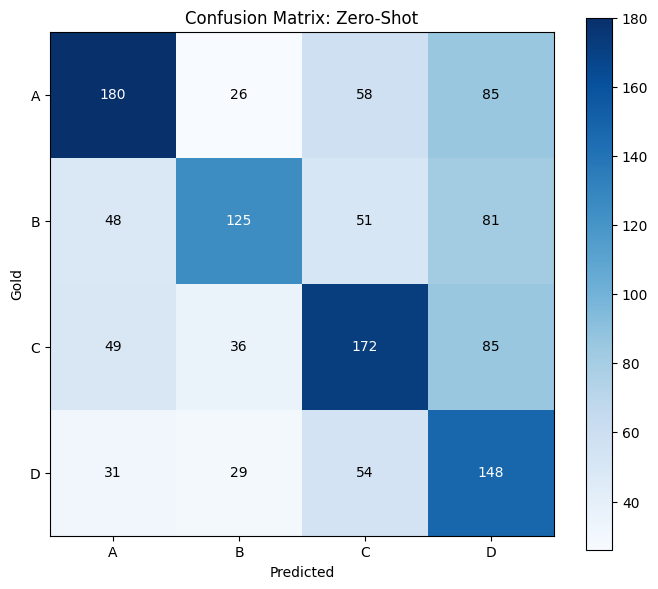

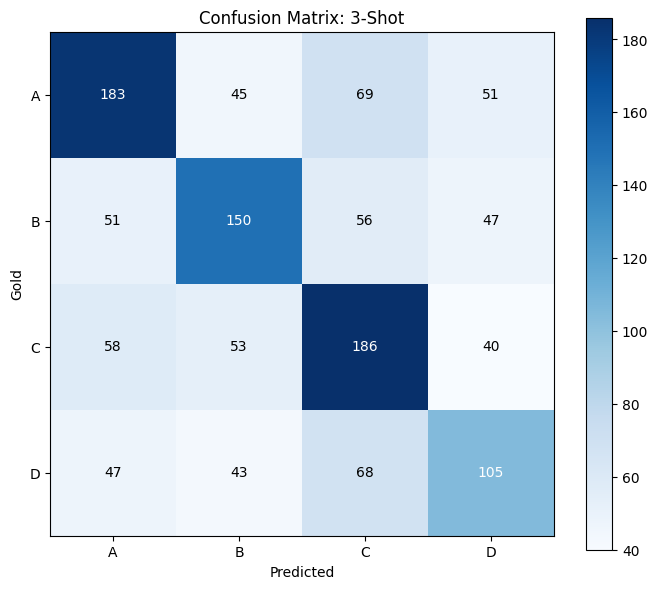

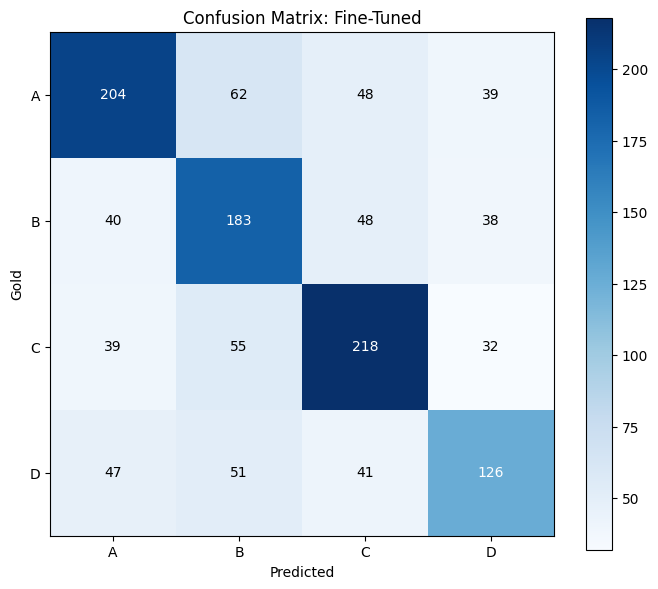

In [ ]:
# ── Confusion Matrix: Fine-Tuned Model ──
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(predictions, title="Confusion Matrix", save_path=None):
    """Plot confusion matrix for A/B/C/D predictions."""
    labels = ["A", "B", "C", "D"]
    gold = [p["gold"] for p in predictions if p["pred"] in labels]
    pred = [p["pred"] for p in predictions if p["pred"] in labels]

    cm = confusion_matrix(gold, pred, labels=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(len(labels)), yticks=np.arange(len(labels)),
           xticklabels=labels, yticklabels=labels,
           xlabel="Predicted", ylabel="Gold", title=title)

    thresh = cm.max() / 2.0
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

# Confusion matrices for all three evaluation modes
for name, results in results_for_bias.items():
    safe_name = name.lower().replace("-", "_").replace(" ", "_")
    plot_confusion_matrix(
        results["predictions"],
        title=f"Confusion Matrix: {name}",
        save_path=os.path.join(RESULTS_DIR, f"confusion_matrix_{safe_name}.png"),
    )

## 13. Prompt Template Sensitivity

How robust is the fine-tuned model to changes in the system prompt? Since the model was trained with a specific prompt template, we test whether rephrasing the instructions affects accuracy. This reveals whether the model learned to answer medical questions generally, or merely memorized the training prompt format.

**Templates tested:**
| Template | Description |
|----------|-------------|
| original | Full system prompt used during training |
| minimal | Bare instruction — just "answer with a letter" |
| cot_style | Adds "think step by step" instruction |
| role_emphasis | Emphasizes physician role and exam context |

In [ ]:
# Define alternate system prompts to test sensitivity
from src.data_loader import format_question
from src.evaluator import run_inference_batch, extract_answer_letter

PROMPT_TEMPLATES = {
    "original": (
        "You are a medical expert. Answer the following USMLE-style "
        "multiple-choice question by selecting the single best answer. "
        "Respond with ONLY the letter (A, B, C, or D) of the correct answer."
    ),
    "minimal": (
        "Answer with only the letter of the correct option (A, B, C, or D)."
    ),
    "cot_style": (
        "You are a medical expert. Think step by step about this USMLE-style "
        "question, then provide your final answer as a single letter "
        "(A, B, C, or D)."
    ),
    "role_emphasis": (
        "You are an experienced physician taking the USMLE Step 1 exam. "
        "For each question, select the single best answer. "
        "Respond with ONLY the letter (A, B, C, or D)."
    ),
}

def format_with_template(example, system_prompt):
    """Format a question using a custom system prompt in Mistral instruct format."""
    question_text = format_question(example)
    user_content = f"{system_prompt}\n\n{question_text}"
    return f"<s>[INST] {user_content} [/INST]"

# Run inference with each template on the fine-tuned model
template_results = {}

for template_name, system_prompt in PROMPT_TEMPLATES.items():
    print(f"\nRunning template: {template_name}")
    prompts = [format_with_template(ex, system_prompt) for ex in test_raw]
    gold_labels = [LABEL_MAP[ex["label"]] for ex in test_raw]

    raw_outputs = run_inference_batch(
        ft_model, ft_tokenizer, prompts,
        max_new_tokens=5, batch_size=8,
    )

    pred_labels = []
    correct = 0
    extraction_failures = 0

    for raw, gold in zip(raw_outputs, gold_labels):
        pred = extract_answer_letter(raw)
        if pred is None:
            extraction_failures += 1
            pred = "X"
        pred_labels.append(pred)
        if pred == gold:
            correct += 1

    accuracy = correct / len(gold_labels)
    template_results[template_name] = {
        "accuracy": round(accuracy, 4),
        "extraction_failures": extraction_failures,
        "pred_distribution": dict(Counter(pred_labels)),
    }
    print(f"  Accuracy: {accuracy:.4f} | Extraction failures: {extraction_failures}")

# Summary table
print("\n" + "=" * 60)
print("Prompt Template Sensitivity Summary")
print("=" * 60)

template_df = pd.DataFrame([
    {
        "Template": name,
        "Accuracy": f"{res['accuracy']:.4f}",
        "Extraction Failures": res["extraction_failures"],
    }
    for name, res in template_results.items()
])
print(template_df.to_string(index=False))

save_results_json(template_results, os.path.join(RESULTS_DIR, "prompt_template_results.json"))


Running template: original
  Accuracy: 0.5742 | Extraction failures: 2

Running template: minimal
  Accuracy: 0.5750 | Extraction failures: 2

Running template: cot_style
  Accuracy: 0.5687 | Extraction failures: 2

Running template: role_emphasis
  Accuracy: 0.5766 | Extraction failures: 2

Prompt Template Sensitivity Summary
     Template Accuracy  Extraction Failures
     original   0.5742                    2
      minimal   0.5750                    2
    cot_style   0.5687                    2
role_emphasis   0.5766                    2


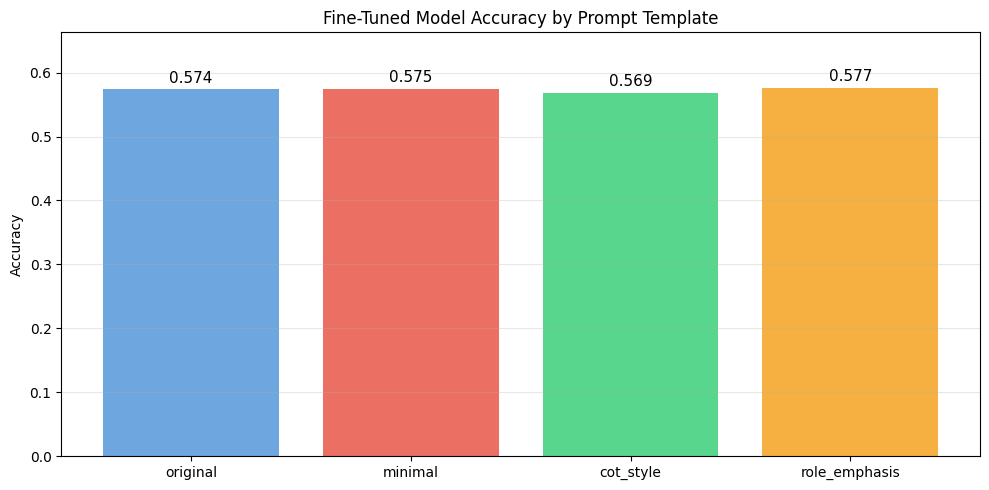


Prediction distribution by template:
  original: {'A': 330, 'B': 351, 'C': 355, 'D': 235, 'X': 2}
  minimal: {'A': 328, 'D': 247, 'B': 327, 'C': 369, 'X': 2}
  cot_style: {'A': 348, 'C': 364, 'B': 336, 'D': 223, 'X': 2}
  role_emphasis: {'A': 315, 'D': 247, 'B': 344, 'C': 365, 'X': 2}


In [ ]:
# ── Prompt Template Sensitivity: Comparison Plot ──

fig, ax = plt.subplots(figsize=(10, 5))

names = list(template_results.keys())
accs = [template_results[n]["accuracy"] for n in names]
colors = ["#4a90d9", "#e74c3c", "#2ecc71", "#f39c12"]

bars = ax.bar(names, accs, color=colors[:len(names)], alpha=0.8)
ax.set_ylabel("Accuracy")
ax.set_title("Fine-Tuned Model Accuracy by Prompt Template")
ax.set_ylim(0, max(accs) * 1.15)
ax.grid(True, axis="y", alpha=0.3)

for bar, acc in zip(bars, accs):
    ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 0.005,
            f"{acc:.3f}", ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "prompt_template_comparison.png"),
            dpi=150, bbox_inches="tight")
plt.show()

# Prediction distribution per template
print("\nPrediction distribution by template:")
for name, res in template_results.items():
    print(f"  {name}: {res['pred_distribution']}")

In [ ]:
# Clean up
del ft_model
torch.cuda.empty_cache()

## 14. Summary & Conclusions

### Why QLoRA?

We chose QLoRA over full fine-tuning because Mistral-7B requires approximately 56GB of VRAM for full fine-tuning (7B parameters x 8 bytes for AdamW optimizer states), which exceeds the 40-80GB available on a single A100/H100 GPU. QLoRA addresses this through three techniques:

1. **4-bit NF4 quantization** compresses the base model from ~14GB (float16) to ~4GB in GPU memory
2. **LoRA adapters** inject small trainable matrices into the model's attention and MLP layers, reducing trainable parameters to ~1% of the total (e.g. 42M out of 3.8B)
3. **Gradient checkpointing** trades compute for memory by recomputing activations during the backward pass

This combination allows fine-tuning to fit comfortably in ~15-20GB of VRAM.

### Key Findings

1. **Fine-tuning improved test accuracy from 49.1% (zero-shot) to 57.4% (+8.3 points).** This represents a meaningful improvement over the base model, raising performance from near-random (25% baseline for 4-option MCQ) toward clinically-aware reasoning.

2. **Few-shot prompting provided no benefit.** The 3-shot baseline (49.0%) performed marginally worse than zero-shot (49.1%), suggesting that in-context exemplars may confuse a 7B model more than they help on complex medical reasoning tasks. This contrasts with larger models (e.g. GPT-4) where few-shot prompting is highly effective.

3. **Learning rate was the most impactful hyperparameter.** Config 4 (lr=5e-5) outperformed all other configurations at 57.4% accuracy. The slower learning rate allowed training to continue for ~1500 steps without overfitting, compared to configs with lr=2e-4 which diverged by step 600.

4. **LoRA rank had minimal impact.** Configs 1-3 varied rank from 8 to 64 (0.55% to 4.27% trainable parameters) but accuracy only varied by ~1% (55.8-56.7%). This indicates the task is constrained by the base model's pre-trained medical knowledge, not adapter capacity.

5. **Aggressive training settings hurt performance.** Config 6 (lr=3e-4, r=32, dropout=0.1) was the worst performer at 51.3%, and Config 5 (3 epochs at lr=2e-4) also underperformed at 53.0%. Both showed severe train-eval loss divergence, confirming that overfitting is the primary risk.

6. **Fine-tuning eliminated extraction failures.** The base model failed to produce a valid A/B/C/D answer 1-1.6% of the time. After fine-tuning, extraction failures dropped to 0.16% (2 out of 1,273), showing the model learned the expected output format.

7. **The model is overconfident.** The Expected Calibration Error (ECE) of 0.254 indicates poor calibration. Average confidence on correct predictions (57.97%) is barely higher than on incorrect predictions (54.42%), meaning the model cannot reliably distinguish when it is right vs wrong.

8. **All models exhibit answer position bias, but fine-tuning reduces it.** Chi-squared tests confirm all three evaluation modes (zero-shot, few-shot, fine-tuned) produce non-uniform answer distributions (p < 0.05). The base model zero-shot has a strong bias toward **D** (+134 over-predicted, 31.7% of predictions vs 20.8% of gold labels) and away from **B** (-93 under-predicted). Fine-tuning significantly reduced the bias severity (chi2 dropped from 55.0 to 29.9), though a mild over-prediction of **B** (+42) and under-prediction of **D** (-30) persists. This suggests the model partially learns answer content rather than just position heuristics.

9. **The fine-tuned model is robust to prompt template changes.** Testing four different system prompts (original, minimal, chain-of-thought, role-emphasis) yielded accuracy within a narrow 0.8% band (56.87%-57.66%). This confirms the model learned to answer medical questions generally, rather than memorizing the specific training prompt format. Notably, the minimal prompt ("Answer with only the letter") performed comparably to the full system prompt, and the role-emphasis prompt ("experienced physician taking USMLE Step 1") achieved the highest accuracy at 57.66%.

### Per-Topic Analysis

Fine-tuning improved accuracy across all 13 medical topics, with the largest gains in:
- **Psychiatry** (+14.7%, from 47.1% to 61.8%)
- **Hematology** (+13.0%, from 37.0% to 50.0%)
- **Endocrinology** (+12.3%, from 40.4% to 52.6%)
- **Cardiology** (+11.8%, from 50.2% to 62.0%)

The weakest topics after fine-tuning were **Pharmacology** (37.5%, though only 8 test examples) and **Neurology** (47.7%). These topics may require more specialized reasoning that the base model's pre-training did not adequately cover.

### Error Analysis

Of 1,273 test examples, the fine-tuned model made 542 errors (42.6% error rate):
- **540 substantive errors** where the model selected the wrong answer
- **2 extraction failures** where no valid answer was produced

The most confused answer pairs were A->B (62 times), C->B (55 times), and D->B (51 times), consistent with the position bias analysis showing a mild over-prediction of B. Answer D had the lowest recall at 0.48, possibly reflecting both its lower representation in the training data and the model's tendency to shift predictions away from the D position.

### Limitations

1. **Knowledge ceiling from pre-training.** The ~57% accuracy ceiling appears to be set by Mistral-7B's pre-trained medical knowledge, not by the fine-tuning method. All 6 hyperparameter configurations converged to similar eval loss (~0.95-0.98), suggesting LoRA can teach the output format but cannot inject new medical facts.

2. **Persistent position bias.** Despite reducing bias severity, fine-tuning did not eliminate answer position bias entirely (chi2=29.9, p<0.001). The over-prediction of B and under-prediction of D could be addressed in future work through answer-shuffled training, where option positions are randomized during training to prevent positional shortcuts.

3. **Heuristic topic classifier.** Our keyword-based topic tagger is approximate -- questions spanning multiple topics (e.g. a cardiology question involving pharmacology) may be misclassified, affecting per-topic accuracy estimates.

4. **Single model family.** We only evaluated Mistral-7B-Instruct-v0.3. Other architectures (Llama-3-8B, Phi-3) may have different pre-trained medical knowledge and could yield different results under the same fine-tuning setup.

5. **No chain-of-thought reasoning.** The model was trained to output a single letter (A/B/C/D) without explaining its reasoning. Chain-of-thought training, where the model generates an explanation before answering, has been shown to improve accuracy on multi-step reasoning tasks. Notably, the CoT-style prompt template slightly reduced accuracy (56.87% vs 57.42%), likely because the model was fine-tuned for direct letter output and the 5-token generation limit prevents actual reasoning.

6. **Dataset scope.** MedQA covers USMLE content only, which reflects US medical practice, drug formularies, and clinical guidelines. Performance may not generalize to other medical contexts.

### Ethical Considerations

1. **Clinical risk.** At 57.4% accuracy, the model answers incorrectly on nearly half of medical questions. It must NOT be used for clinical decision-making. Even significantly higher accuracy (e.g. 90%) would require rigorous validation before any clinical application.

2. **Cultural bias.** USMLE-based training data reflects US-centric medical practice. The model may perform worse on medical questions involving non-US treatment protocols, drug availability, or disease prevalence patterns.

3. **Overconfidence.** The calibration analysis (ECE = 0.254) shows the model is poorly calibrated -- it cannot reliably signal when it is uncertain. This is particularly dangerous in a medical context where a confident wrong answer could lead to harm if the model were misused.

4. **Demographic blind spots.** Clinical vignettes in MedQA may underrepresent certain patient demographics (age groups, ethnicities, socioeconomic backgrounds), potentially leading to performance disparities across populations.

### Alternative Design Choices

If the model did not improve or to push beyond the current accuracy ceiling, several alternative approaches could be considered:

- **Answer shuffling during training.** Randomly permuting option positions (A/B/C/D) during training forces the model to learn answer content rather than positional shortcuts. Our position bias analysis shows this would likely improve performance on under-predicted positions (especially D, which has only 0.48 recall).
- **Chain-of-thought fine-tuning.** Training on "Question -> Explanation -> Answer" sequences rather than direct letter prediction. This forces the model to engage its reasoning capabilities and has been shown to improve accuracy on medical QA tasks.
- **Retrieval-Augmented Generation (RAG).** Augmenting the model with a retrieval system that fetches relevant medical textbook passages before answering. This directly addresses the knowledge ceiling by providing external evidence at inference time.
- **Prompt engineering (Medprompt).** Microsoft Research demonstrated that GPT-4 with careful prompting strategies (self-generated chain-of-thought, choice shuffling, majority voting) can reach 90%+ on MedQA without any fine-tuning.
- **Larger base model.** Fine-tuning a 70B parameter model (e.g. Llama-3-70B) with QLoRA would provide a richer pre-trained knowledge base, though at significantly higher compute cost.
- **Data augmentation.** Incorporating additional medical QA datasets such as MedMCQA (183K Indian medical exam questions) or MMLU medical subsets could broaden the training distribution.

### Reproducibility

- **Model:** `mistralai/Mistral-7B-Instruct-v0.3`
- **Dataset:** `GBaker/MedQA-USMLE-4-options-hf` (10,178 train / 1,272 val / 1,273 test)
- **Method:** QLoRA with 4-bit NF4 quantization, bfloat16 compute dtype, double quantization
- **Best config:** lr=5e-5, r=16, alpha=32, cosine schedule, 3 epochs, early stopping (patience=3)
- **Libraries:** transformers, peft, trl, bitsandbytes (see `pyproject.toml` for versions)
- **Seed:** 42
- **Compute:** Google Colab, NVIDIA H100 80GB HBM3
- **Total training time:** ~3.5 hours for all 6 configurations
- **All code:** Available in `src/` directory with modular architecture

**Note on saved artifacts:** All 6 LoRA adapters (`adapter_model.safetensors`) and training checkpoints (including full optimizer states and gradients) were produced and saved to Google Drive during training. Each config's adapter is stored in its `adapter/` subdirectory, and intermediate checkpoints (with optimizer/scheduler state for potential training resumption) are in `checkpoint-*/` subdirectories. These artifacts are not included in the git repository due to their size (~160 MB each) but are regenerated automatically when the training pipeline is executed.